# Third-order Lax-Wendroff
Derivations and summary results are presented in file LW_ImEx.lyx

In [1]:
#For the LaTeX equations (such as eqnarray) in this document to work, include the following in file
#~/.jupyter/_config.yml
#
#parse:
#  myst_enable_extensions:  # default extensions to enable in the myst parser. See https://myst-parser.readthedocs.io/en/latest/using/syntax-optional.html
#     - amsmath
#
#(the default ~/.jupyter/_config.yml will have amsmath commented out)
#
#This notebook uses sympy and sparse linear algegra
import numpy as np
from numpy import exp
import sympy as sy
from sympy.matrices import Matrix, MatrixSymbol
from fractions import Fraction as Fr
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np
# Convension is that symbols start with capital letters

In [2]:
# Derivation of LW3 using spatial gradients from a cubic polynomial
PolyCoeffs = sy.Matrix(sy.symarray("PolyCoeffs", (4,))) # Coefficients a,b,c,d of the polynomial
Psi = sy.Matrix(sy.symarray("Psi", (4,)), real=True)    # Grid point values at i-2, i-1, i and i+1
polyM = Matrix([[-8,4,-2,1], [-1,1,-1,1], [0,0,0,1], [1,1,1,1]])
PolyCoeffs = polyM.solve(Psi)
Ddx = PolyCoeffs[2]
D2dx2 = 2*PolyCoeffs[1]
D3dx3 = 6*PolyCoeffs[0]
print('d/dx =', Ddx, '\nd2/dx2 =', D2dx2, '\nd3/dx3 =', D3dx3)
# From this we can work out the explicit LW3e  increment
[C, Chi2, Chi3] = sy.symbols("C, Chi2, Chi3", real=True)   # The Courant number and the HO limiters
LW3e = - C*Ddx + Chi2*C**2/2*D2dx2 - Chi3*C**3/6*D3dx3
print('LW3e increment is', LW3e)
print('LW3e increment as coefficients of grid points is\n', sy.collect(sy.expand(LW3e), Psi))
# The implicit LW3i scheme
LW3i = - C*Ddx - Chi2*C**2/2*D2dx2 - Chi3*C**3/6*D3dx3
print('LW3i increment is ', LW3i)
print('LW3i increment as coefficients of grid points is\n', sy.collect(sy.expand(LW3i), Psi))

d/dx = Psi_0/6 - Psi_1 + Psi_2/2 + Psi_3/3 
d2/dx2 = Psi_1 - 2*Psi_2 + Psi_3 
d3/dx3 = -Psi_0 + 3*Psi_1 - 3*Psi_2 + Psi_3
LW3e increment is -C**3*Chi3*(-Psi_0 + 3*Psi_1 - 3*Psi_2 + Psi_3)/6 + C**2*Chi2*(Psi_1 - 2*Psi_2 + Psi_3)/2 - C*(Psi_0/6 - Psi_1 + Psi_2/2 + Psi_3/3)
LW3e increment as coefficients of grid points is
 Psi_0*(C**3*Chi3/6 - C/6) + Psi_1*(-C**3*Chi3/2 + C**2*Chi2/2 + C) + Psi_2*(C**3*Chi3/2 - C**2*Chi2 - C/2) + Psi_3*(-C**3*Chi3/6 + C**2*Chi2/2 - C/3)
LW3i increment is  -C**3*Chi3*(-Psi_0 + 3*Psi_1 - 3*Psi_2 + Psi_3)/6 - C**2*Chi2*(Psi_1 - 2*Psi_2 + Psi_3)/2 - C*(Psi_0/6 - Psi_1 + Psi_2/2 + Psi_3/3)
LW3i increment as coefficients of grid points is
 Psi_0*(C**3*Chi3/6 - C/6) + Psi_1*(-C**3*Chi3/2 - C**2*Chi2/2 + C) + Psi_2*(C**3*Chi3/2 + C**2*Chi2 - C/2) + Psi_3*(-C**3*Chi3/6 - C**2*Chi2/2 - C/3)


Amplification factor for LW3 ImEx is 
 ((1 - Alp)*(-C**3*Chi3*(exp(I*Kdx) - 3 + 3*exp(-I*Kdx) - exp(-2*I*Kdx))/6 + C**2*Chi2*(exp(I*Kdx) - 2 + exp(-I*Kdx))/2 - C*(exp(I*Kdx)/3 + 1/2 - exp(-I*Kdx) + exp(-2*I*Kdx)/6)) + 1)/(-Alp*(-C**3*Chi3*(exp(I*Kdx) - 3 + 3*exp(-I*Kdx) - exp(-2*I*Kdx))/6 - C**2*Chi2*(exp(I*Kdx) - 2 + exp(-I*Kdx))/2 - C*(exp(I*Kdx)/3 + 1/2 - exp(-I*Kdx) + exp(-2*I*Kdx)/6)) + 1)


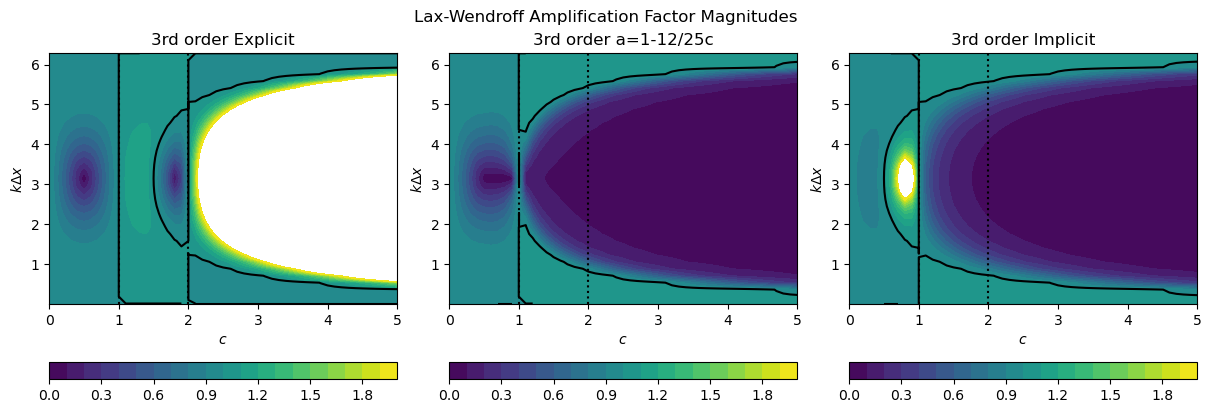

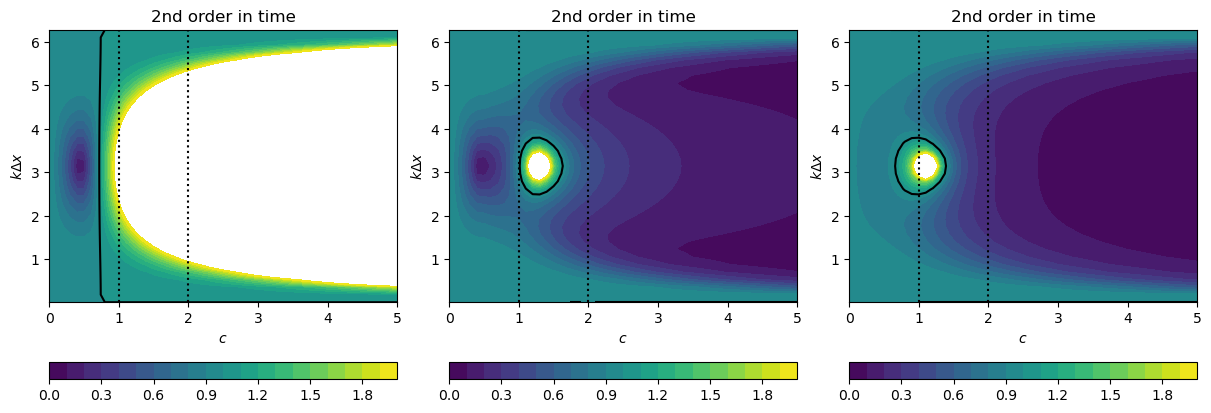

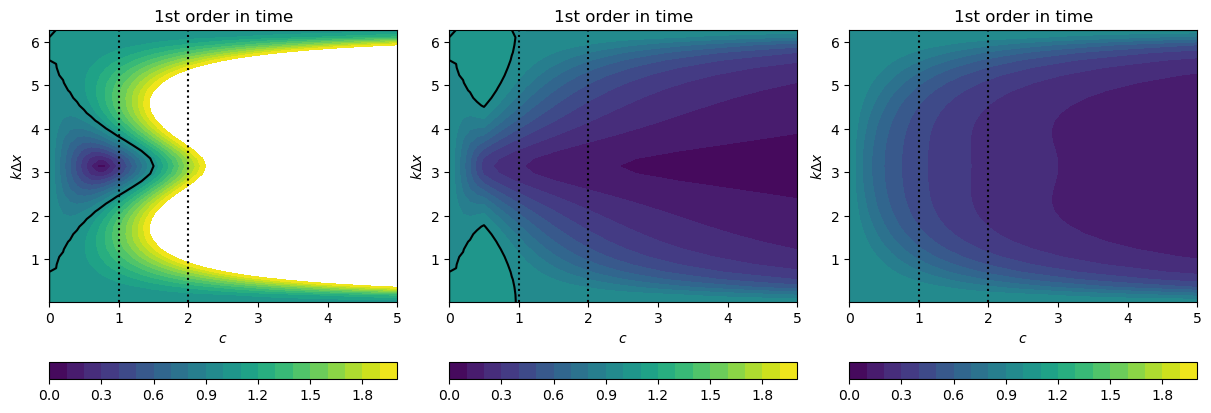

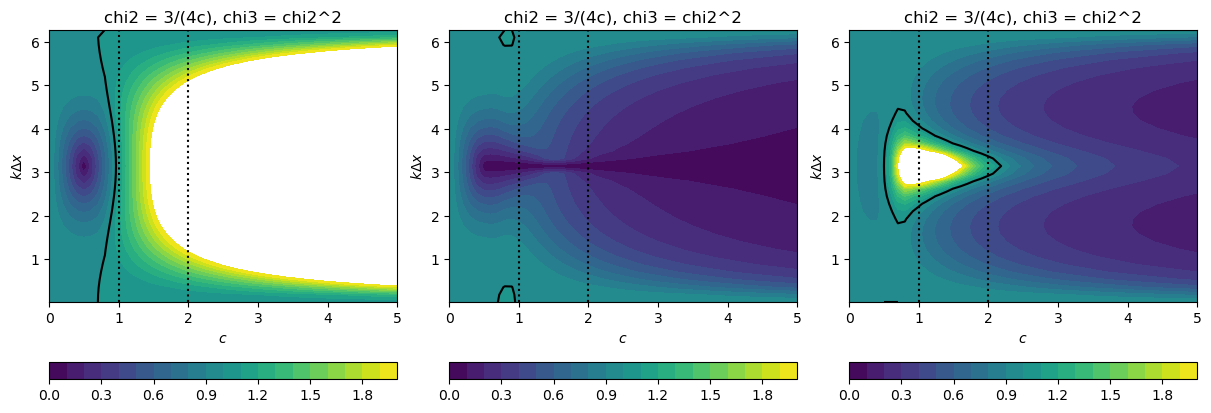

In [3]:
# Stability Analysis of LW3 AdImEx

# The amplification factor for LW3_AdImEx
[Kdx, Alp] = sy.symbols("Kdx, Alp", real=True)
A_LW3ImEx0 = (1 + (1-Alp)*LW3e)/(1 - Alp*LW3i)
A_LW3ImEx = A_LW3ImEx0.subs({Psi[0] : sy.E**(-2*sy.I*Kdx), Psi[1] : sy.E**(-sy.I*Kdx), Psi[2] : 1, Psi[3] : sy.E**(sy.I*Kdx)})
print('Amplification factor for LW3 ImEx is \n', A_LW3ImEx)

def alpha(co):
    return np.maximum(0, 1-12/(25*np.maximum(co, 0.1)))

def chi(co):
    return {"chi2": np.minimum(1,3/4/np.maximum(co, 0.1)),
            "chi3": np.minimum(1,9/16/np.maximum(co, 0.1)**2)}

A_LW3 = sy.lambdify([C, Alp, Kdx, Chi2, Chi3], A_LW3ImEx, 'numpy')

a =     [0, alpha, 1]
chis =  [{"chi2":1, "chi3":1}, {"chi2":1, "chi3":0}, {"chi2":0, "chi3":0}, chi]
titles = [["3rd order Explicit", "3rd order a=1-12/25c", "3rd order Implicit"], 
          ["2nd order in time", "2nd order in time", "2nd order in time"], 
          ["1st order in time", "1st order in time", "1st order in time"], 
          ["chi2 = 3/(4c), chi3 = chi2^2", "chi2 = 3/(4c), chi3 = chi2^2", "chi2 = 3/(4c), chi3 = chi2^2"]]

kdxs = np.linspace(1e-6, 2*np.pi, 37)
cs = np.arange(0, 5.1, 0.1)
magA = np.zeros([len(kdxs), len(cs)])
for ich in range(len(chis)):
    fig,axs = plt.subplots(1,len(a), figsize=(12,4), layout='constrained')
    if ich == 0:
        fig.suptitle("Lax-Wendroff Amplification Factor Magnitudes")
    for i in range(len(a)):
        for ic in range(len(cs)):
            co = cs[ic]
            ai = a[i]
            if callable(a[i]):
                ai = a[i](co)
            ch = chis[ich]
            if callable(ch):
                ch = ch(co)
            for ik in range(len(kdxs)):
                kdx = kdxs[ik]
                magA[ik,ic] = abs(A_LW3(co, ai,kdx, ch["chi2"], ch["chi3"]))
        axplot = axs[i].contourf(cs, kdxs,magA, np.arange(0, 2.1, 0.1))
        axs[i].axvline(x=1, color="black", linestyle=":")
        axs[i].axvline(x=2, color="black", linestyle=":")
        fig.colorbar(axplot,ax=axs[i], orientation='horizontal')
        axs[i].contour(cs, kdxs, magA, [0, 1], colors=['k', 'k'])
        axs[i].set(xlabel=r'$c$', ylabel=r'$k\Delta x$', title = titles[ich][i])

    plt.show()

((1 - Alp)*(4*C**3/3 - 2*C**2 - 4*C/3) + 1)/(-Alp*(4*C**3/3 + 2*C**2 - 4*C/3) + 1)


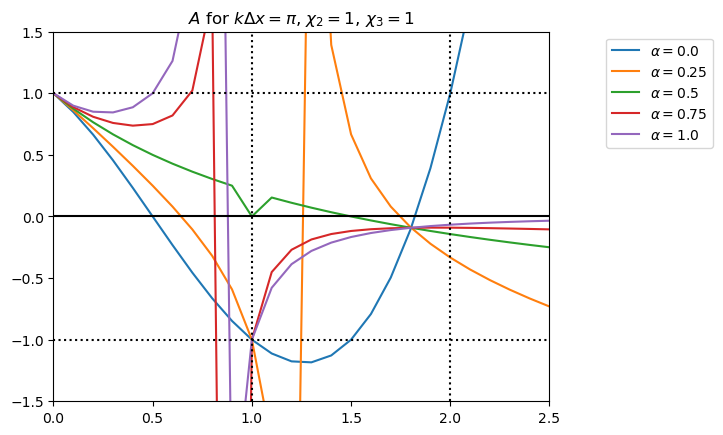

((1 - Alp)*(-C**3*(-3 + 3*exp(-I*pi/6) + exp(I*pi/6) - exp(-I*pi/3))/6 + C**2*(-2 + exp(-I*pi/6) + exp(I*pi/6))/2 - C*(1/2 + exp(-I*pi/3)/6 + exp(I*pi/6)/3 - exp(-I*pi/6))) + 1)/(-Alp*(-C**3*(-3 + 3*exp(-I*pi/6) + exp(I*pi/6) - exp(-I*pi/3))/6 - C**2*(-2 + exp(-I*pi/6) + exp(I*pi/6))/2 - C*(1/2 + exp(-I*pi/3)/6 + exp(I*pi/6)/3 - exp(-I*pi/6))) + 1)


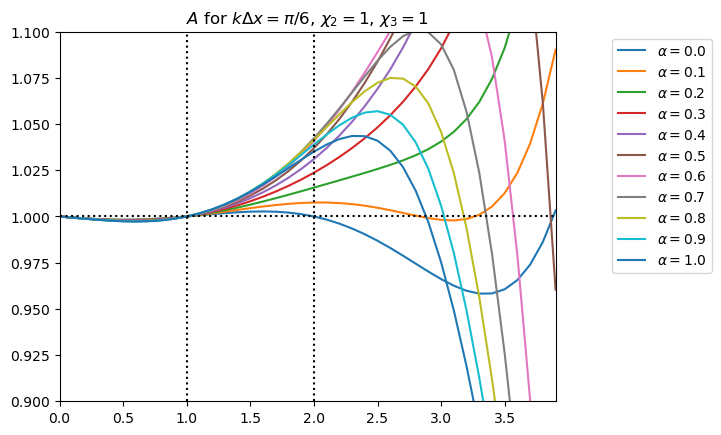

In [4]:
# Find alpha(c) so that 3rd order is stable for c in [0,2]
# First consider kDx = pi
A_LW3Grid = A_LW3ImEx.subs({Kdx : sy.pi, Chi2: 1, Chi3: 1})
AGrid = sy.lambdify([C,Alp], A_LW3Grid, 'numpy')
print(A_LW3Grid)
# Plots of A for kdx = pi
cs = np.arange(0, 2.6, 0.1)
for a in np.arange(0, 1.1, 0.25):
    plt.plot(cs, AGrid(cs, a).real, label = r'$\alpha=$'+str(round(a,2)))
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlim([0,3])
plt.title(r'$A$ for $k\Delta x=\pi$, $\chi_2=1$, $\chi_3=1$')
plt.axhline(y=-1, ls=':', color='k')
plt.axhline(y=0, ls='-', color='k')
plt.axhline(y=1, ls=':', color='k')
plt.axvline(x=1, ls=':', color='k')
plt.axvline(x=2, ls=':', color='k')
plt.xlim([np.amin(cs), np.amax(cs)])
plt.ylim([-1.5,1.5])
plt.show()

# Next for kDx = pi/N
AN = A_LW3ImEx.subs({Kdx : sy.pi/6, Chi2: 1, Chi3: 1})
An = sy.lambdify([C,Alp], AN, 'numpy')
print(AN)
# Plots of A for kdx = pi/N
cs = np.arange(0, 4, 0.1)
for a in np.arange(0, 1.1, 0.1):
    plt.plot(cs, abs(An(cs, a)), label = r'$\alpha=$'+str(round(a,2)))
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlim([0,3])
plt.title(r'$A$ for $k\Delta x=\pi/6$, $\chi_2=1$, $\chi_3=1$')
plt.axhline(y=1, ls=':', color='k')
plt.axvline(x=1, ls=':', color='k')
plt.axvline(x=2, ls=':', color='k')
plt.xlim([np.amin(cs), np.amax(cs)])
plt.ylim([1-0.1,1+.1])
plt.show()

A_LW3Grid =  (1 + (4*C*D**2/3 - 2*C*D - 4*C/3)/(C*E))/(-(1 - 1/(C*E))*(4*C*D**2/3 + 2*C*D - 4*C/3) + 1)
Zero at  3/4 - sqrt(25 - 12*E)/4
For e= 25/12 d = 3/4
Largest imaginary comonent is  1.8270785592449053e-16
Largest imaginary comonent is  1.4277031337928613e-16
Largest imaginary comonent is  1.1133152719521387e-16
Largest imaginary comonent is  2.8473109688094755e-15


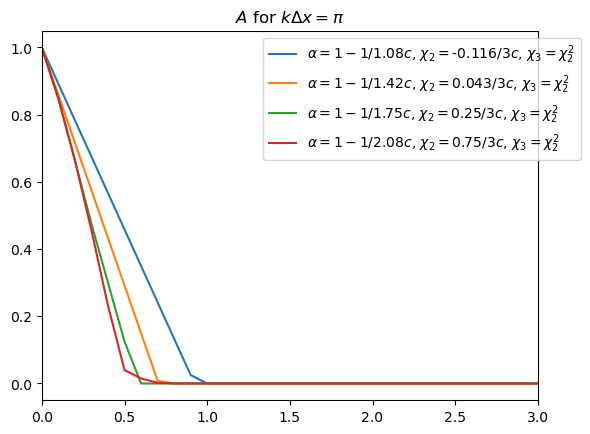

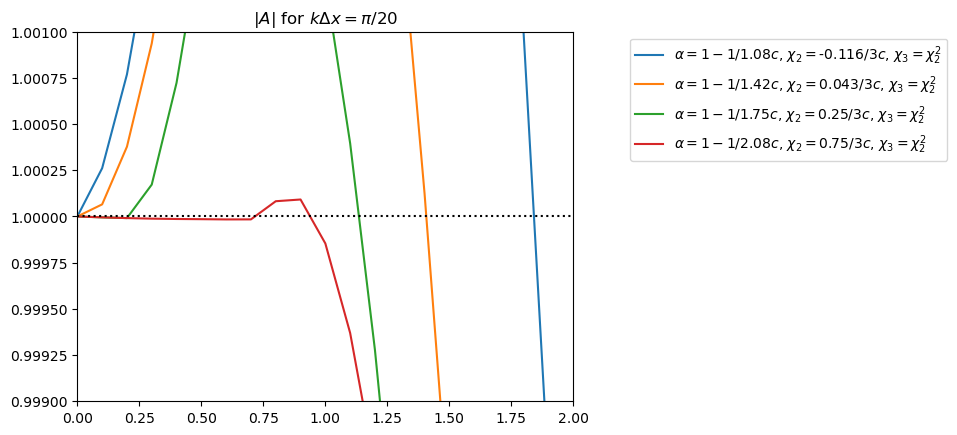

In [5]:
# Analysis for kdx=pi and pi/X,  Find chi2 and chi3 to give A=0
piBy = 20
# Find limit for chi2 and chi3=chi2^2 for alpha = 1-1/(E*c) using D = chi2 c
[D, E] = sy.symbols("D, E", real=True)
A_LW3Grid = A_LW3ImEx.subs({Kdx : sy.pi,  Alp: 1 - 1/(E*C), Chi2: D/C, Chi3: D**2/C**2})
print('A_LW3Grid = ', A_LW3Grid)
DByE = sy.solve(A_LW3Grid, D)[0]
print('Zero at ', DByE)
print('For e=', Fr(25,12), 'd =', DByE.subs({E:Fr(25,12)}))

dBye = sy.lambdify([E], DByE, 'numpy')

def alpha2(c,e):
    return np.maximum(0, 1-1/(e*np.maximum(c, 1e-6)))
    #return np.maximum(0, 1-1/(e*(c + 0.1)))

def chi2(c,d):
    return np.minimum(1, d/np.maximum(c, 1e-6))
    #return np.minimum(1, d/(c + 0.1))

# Plots of A for kdx = pi
cs = np.arange(0, 5.1, 0.1)
for e in np.arange(13/12, 25.5/12, 4/12):
    a = alpha2(cs, e)
    d = dBye(e)
    chi_ = chi2(cs,d)
    plt.plot(cs, A_LW3(cs, a, np.pi, chi_, chi_**2).real,
             label = r'$\alpha=1-1/$'+str(round(e,2))+r'$c$, $\chi_2=$'+str(round(d,3))
                     +r'$/3c$, $\chi_3 = \chi_2^2$')
    print('Largest imaginary comonent is ', np.amax(abs(A_LW3(cs, a, np.pi, chi_, chi_**2).imag)))
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlim([0,3])
plt.title(r'$A$ for $k\Delta x=\pi$')
plt.show()

# Plots of |A| for kdx = pi/X
for e in np.arange(13/12, 25.5/12, 4/12):
    a = alpha2(cs, e)
    d = dBye(e)
    chi_ = chi2(cs,d)
    plt.plot(cs, abs(A_LW3(cs, a, np.pi/piBy, chi_, chi_**2)),
             label = r'$\alpha=1-1/$'+str(round(e,2))+r'$c$, $\chi_2=$'+str(round(d,3))
                     +r'$/3c$, $\chi_3 = \chi_2^2$')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.axhline(y=1, ls=':', color='k')
plt.xlim([0,2])
plt.ylim([1-0.001, 1+0.001])
plt.title(r'$|A|$ for $k\Delta x=\pi/$'+str(piBy))
plt.show()

In [6]:
# Implimentation of LW3_AdImEx scheme symbolically

def LW3iMatrix(nx, c, a, chi2, chi3):
    """The matrix for the implicit part of LW3_ImEx. 
    nx: nx by nx matrix
    c: Courant number
    a: Off-centering
    chi2: fraction of 2nd-order in time terms
    chi3: fraction of 3rd-order in time terms"""

    # The coefficients for j-2, j-1, j, j+1
    #                       0    1   2   3
    m = np.zeros(len(Psi))
    for j in range(len(Psi)):
        M_j = sy.expand(LW3i).coeff(Psi[j])
        m[j] = -a*M_j.subs({C: c, Chi2:chi2, Chi3: chi3})
    m[2] += 1
    
    M = diags([m[3], # The bottom left corner for j+1
               m[0]*np.ones(nx-2), # The diagonal for j-2
               m[1]*np.ones(nx-1), # The diagonal for j-1
               m[2]*np.ones(nx), # The diagonal
               m[3]*np.ones(nx-1), # The diagonal for j+1
               m[0]*np.ones(2), # the diagonal next to the top right  corner (j-2)
               m[1]], # the top right corner (j-1)
               [-nx+1, -2, -1, 0, 1, nx-2, nx-1], # the locations of each of the diagonals
               shape=(nx,nx), format = 'csr')
    return M

def LW3eMatrix(nx, c, a, chi2, chi3):
    """The matrix for the explicit part of LW3_ImEx. 
    nx: nx by nx matrix
    c: Courant number
    a: Off-centering
    chi2: fraction of 2nd-order in time terms
    chi3: fraction of 3rd-order in time terms"""

    # The coefficients for j-2, j-1, j, j+1
    #                       0    1   2   3
    m = np.zeros(len(Psi))
    for j in range(len(Psi)):
        M_j = sy.expand(LW3e).coeff(Psi[j])
        m[j] = +(1-a)*M_j.subs({C: c, Chi2:chi2, Chi3: chi3})
    m[2] += 1
    
    M = diags([m[3], # The bottom left corner for j+1
               m[0]*np.ones(nx-2), # The diagonal for j-2
               m[1]*np.ones(nx-1), # The diagonal for j-1
               m[2]*np.ones(nx), # The diagonal
               m[3]*np.ones(nx-1), # The diagonal for j+1
               m[0]*np.ones(2), # the diagonal next to the top right  corner (j-2)
               m[1]], # the top right corner (j-1)
               [-nx+1, -2, -1, 0, 1, nx-2, nx-1], # the locations of each of the diagonals
               shape=(nx,nx), format = 'csr')
    return M

def advect(phi, Me, Mi):
    """Advect profile phi for one time step with implicit matrix Me and implicit matrix Mi"""
    return spsolve(Mi, Me*phi)

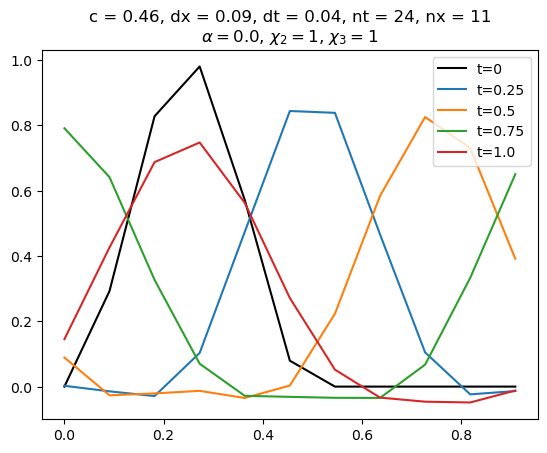

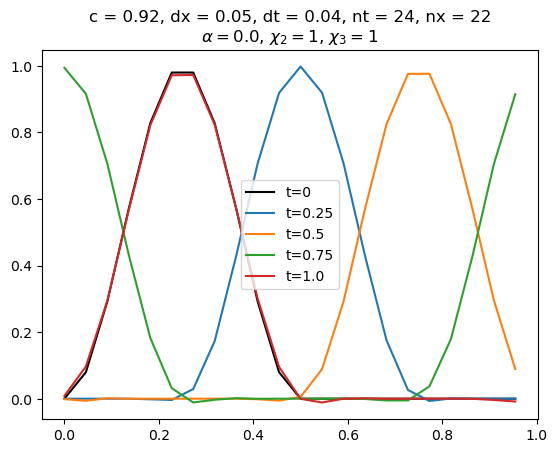

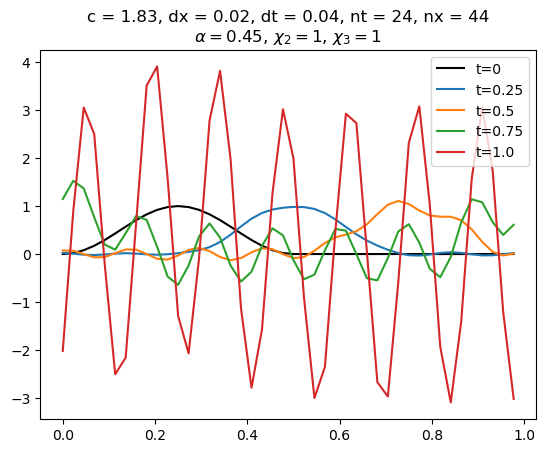

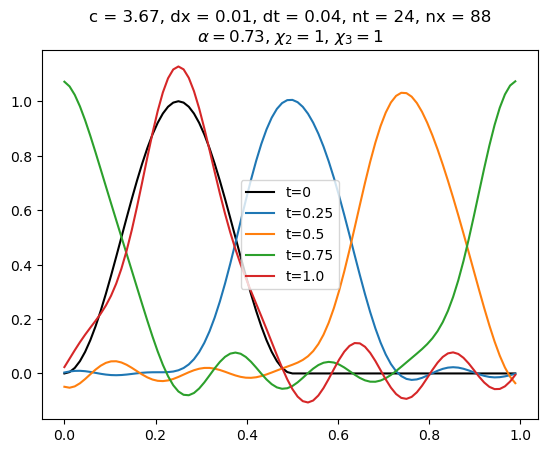

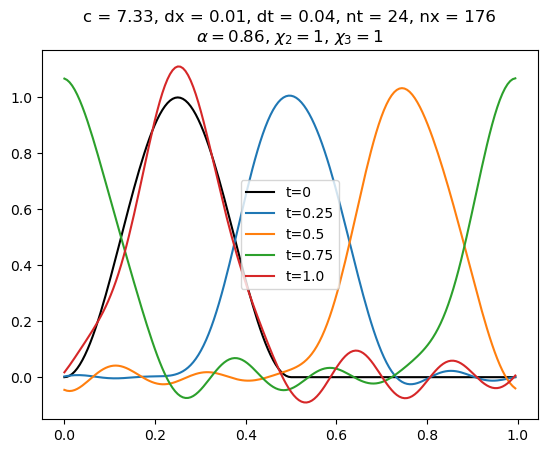

In [7]:
# Model runs of LW3_ImEx

# Parameters for some revolutions of the periodic domain
nRevs = 1
nt = 24*nRevs
plotFreq = 6
dt = nRevs/nt
nxs = np.array([11, 22, 44, 88, 176])

for i in range(len(nxs)):
    nx = nxs[i]
    c = nRevs*nx/nt
    a = alpha2(c,1)
    #chi_ = chi(c)
    chi_ = {"chi2": 1, "chi3": 1}
    Me = LW3eMatrix(nx, c, a, chi_["chi2"], chi_["chi3"])
    Mi = LW3iMatrix(nx, c, a, chi_["chi2"], chi_["chi3"])
    
    dx = 1/nx
    x = np.arange(0, 1, dx)
    phi0 = np.where(x<0.5, 0.5*(1-np.cos(4*np.pi*x)), 0.)
    phi = phi0.copy()
    plt.plot(x, phi, 'k', label = 't=0')
    for it in range(nt):
        phi = advect(phi, Me, Mi)
        if (it+1)%plotFreq == 0:
            plt.plot(x, phi, label = 't='+str(round((it+1)*dt, 2)))
    plt.legend()
    plt.title('c = '+str(round(c,2))+', dx = '+str(round(dx,2))+', dt = '+str(round(dt,2))
               +', nt = '+str(nt)+', nx = '+str(nx) + '\n'
         +r'$\alpha=$'+str(round(a,2))+r', $\chi_2=$'+str(round(chi_["chi2"],2))
         +r', $\chi_3=$'+str(round(chi_["chi3"],2)))
    plt.show()

# Warming and Beam Second-Order derivation

In [8]:
# Derivation of WB2 using spatial gradients from a quadratic
# ax^2 + bx + c  so that ddx = 2ax + b, d2/dx2 = 2a
[C, Chi2] = sy.symbols("C, Chi2", real=True)   # The Courant number and the HO limiter
#Psi = sy.Matrix(sy.symarray("Psi", (3,)))      # Grid point values at i-2,i-1 and i

def findDdxD2dx2():
    PolyCoeffs = sy.Matrix(sy.symarray("PolyCoeffs", (3,))) # Coefficients a,b,c of the polynomial
    polyM = Matrix([[4,-2,1], [1,-1,1], [0,0,1]])
    PolyCoeffs = polyM.solve(sy.Matrix(Psi[0:-1]))
    Ddx = PolyCoeffs[1]
    D2dx2 = 2*PolyCoeffs[0]
    print('d/dx =', Ddx, '\nd2/dx2 =', D2dx2)
    return Ddx, D2dx2

WB_Ddx, WB_D2dx2 = findDdxD2dx2()

# From this we can work out the explicit WB3e  increment
WB2e = - C*WB_Ddx + C**2/2*WB_D2dx2
print('WB2e increment is', WB2e)
print('WB2e increment as coefficients of grid points is\n', sy.collect(sy.expand(WB2e), Psi))
# The implicit WB2i scheme
WB2i = - C*WB_Ddx - C**2/2*WB_D2dx2
print('WB2i increment is ', WB2i)
print('WB2i increment as coefficients of grid points is\n', sy.collect(sy.expand(WB2i), Psi))

d/dx = Psi_0/2 - 2*Psi_1 + 3*Psi_2/2 
d2/dx2 = Psi_0 - 2*Psi_1 + Psi_2
WB2e increment is C**2*(Psi_0 - 2*Psi_1 + Psi_2)/2 - C*(Psi_0/2 - 2*Psi_1 + 3*Psi_2/2)
WB2e increment as coefficients of grid points is
 Psi_0*(C**2/2 - C/2) + Psi_1*(-C**2 + 2*C) + Psi_2*(C**2/2 - 3*C/2)
WB2i increment is  -C**2*(Psi_0 - 2*Psi_1 + Psi_2)/2 - C*(Psi_0/2 - 2*Psi_1 + 3*Psi_2/2)
WB2i increment as coefficients of grid points is
 Psi_0*(-C**2/2 - C/2) + Psi_1*(C**2 + 2*C) + Psi_2*(-C**2/2 - 3*C/2)


# Stability Analysis of LW3e with WB2i

In [9]:
# Stability Analysis of LW3e_WB2i
A_LW3e_WB2i = (1 + (1-Alp)*LW3e)/(1 - Alp*WB2i)
A_LW3e_WB2i = A_LW3e_WB2i.subs({Psi[0] : sy.E**(-2*sy.I*Kdx), Psi[1] : sy.E**(-sy.I*Kdx),
                                Psi[2] : 1, Psi[3] : sy.E**(sy.I*Kdx), Chi2: 1, Chi3: 1})
print('Amplification factor for LW3e_WB2i ImEx is \n', A_LW3e_WB2i)

A_lw3e_wb2i = sy.lambdify([C, Alp, Kdx], A_LW3e_WB2i, 'numpy')

Amplification factor for LW3e_WB2i ImEx is 
 ((1 - Alp)*(-C**3*(exp(I*Kdx) - 3 + 3*exp(-I*Kdx) - exp(-2*I*Kdx))/6 + C**2*(exp(I*Kdx) - 2 + exp(-I*Kdx))/2 - C*(exp(I*Kdx)/3 + 1/2 - exp(-I*Kdx) + exp(-2*I*Kdx)/6)) + 1)/(-Alp*(-C**2*(1 - 2*exp(-I*Kdx) + exp(-2*I*Kdx))/2 - C*(3/2 - 2*exp(-I*Kdx) + exp(-2*I*Kdx)/2)) + 1)


# Symbolic Implimentation of LW3_AdImEx

((1 - Alp)*(4*C**3/3 - 2*C**2 - 4*C/3) + 1)/(-Alp*(-2*C**2 - 4*C) + 1)
alpha to give A=-1 =  (2*C**2 - 5*C + 3)/(2*C*(C - 4))
alpha to give A=0 =  (-4*C**3 + 6*C**2 + 4*C - 3)/(2*C*(-2*C**2 + 3*C + 2))
alpha to give A=1 =  (C**2 - 3*C/2 - 1)/(C**2 + 2)
alphaGrad =  1/6
C1  has  4 solutions
c1 =  0.579638394226551 + 0.666050613333938*I gradient = 0.917377731530277 + 0.828739851148662*I
c1 =  3.61490744247378 + 0.e-21*I gradient = 0.16865863334488 + 1.33462021062943e-26*I
c1 =  0.579638394226551 - 0.666050613333938*I gradient = 0.917377731530277 - 0.828739851148662*I
c1 =  -1.77418423092688 + 0.e-21*I gradient = -0.336747429738766 + 7.69742571951308e-27*I
c1, g =  3.61490744247378 0.168658633344880


<lambdifygenerated-6>:2: RuntimeWarning: divide by zero encountered in divide
  return (1/2)*(2*C**2 - 5*C + 3)/(C*(C - 4))


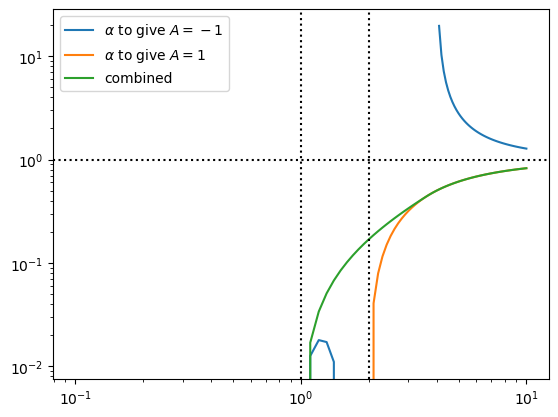

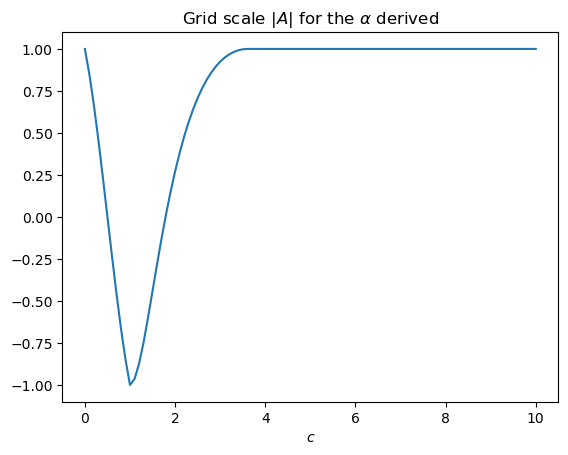

In [10]:
# Stability analysis for kdx = pi
A_LW3e_WB2i_Grid = A_LW3e_WB2i.subs({Kdx: sy.pi})
print(A_LW3e_WB2i_Grid)

# Find alpha(c) to give A = -1 and A = 0
Alpham1 = sy.solve(A_LW3e_WB2i_Grid+1, Alp)[0]
Alpha0 = sy.solve(A_LW3e_WB2i_Grid, Alp)[0]
Alphap1 = sy.solve(A_LW3e_WB2i_Grid-1, Alp)[0]
print('alpha to give A=-1 = ', Alpham1)
print('alpha to give A=0 = ', Alpha0)
print('alpha to give A=1 = ', Alphap1)

alpha_LW_WBm1 = sy.lambdify([C], Alpham1, 'numpy')
alpha_LW_WB0 = sy.lambdify([C], Alpha0, 'numpy')
alpha_LW_WBp1 = sy.lambdify([C], Alphap1, 'numpy')

# Find the gradient of Alpham1 at C=1
dAlphadC = sy.diff(Alpham1, C)
alphaGrad = dAlphadC.subs({C:1})
print('alphaGrad = ', alphaGrad)

# Find the gradient, G, where the line through c=1 touches Alphap1
G = sy.diff(Alphap1, C)
C1 = sy.solve(G - Alphap1/(C-1), C)
print('C1  has ', len(C1), 'solutions')
for C1i in C1:
    print('c1 = ',  C1i.evalf(), 'gradient =', (G.subs({C:C1i})).evalf())
c1 = sy.re(C1[1].evalf())
g = sy.re((G.subs({C:C1[1]})).evalf())
print('c1, g = ', c1, g)

def alpha_LW_WB(c):
    return np.where(c <= 1, 0., np.where(c <= c1, g*(c-1), alpha_LW_WBp1(c)))

cs = np.arange(0, 10.1, 0.1)
plt.loglog(cs, alpha_LW_WBm1(cs), label=r'$\alpha$ to give $A=-1$')
plt.loglog(cs, alpha_LW_WBp1(cs), label=r'$\alpha$ to give $A=1$')
plt.loglog(cs, alpha_LW_WB(cs), label='combined')
plt.legend()
plt.axhline(y=0, color='k')
plt.axhline(y=1, color='k', ls=':')
plt.axvline(x=1, color='k', ls=':')
plt.axvline(x=2, color='k', ls=':')
#plt.ylim([-0.2,1.1])
#plt.xlim([0,5])
plt.show()

# A using the alpha(c) derived
A_lw3e_wb2i_grid = sy.lambdify([C, Alp] ,A_LW3e_WB2i_Grid, 'numpy')
plt.plot(cs, A_lw3e_wb2i_grid(cs, alpha_LW_WB(cs)))
plt.xlabel(r'$c$')
plt.title(r'Grid scale $|A|$ for the $\alpha$ derived')
plt.show()

## Amplification Factor Plots

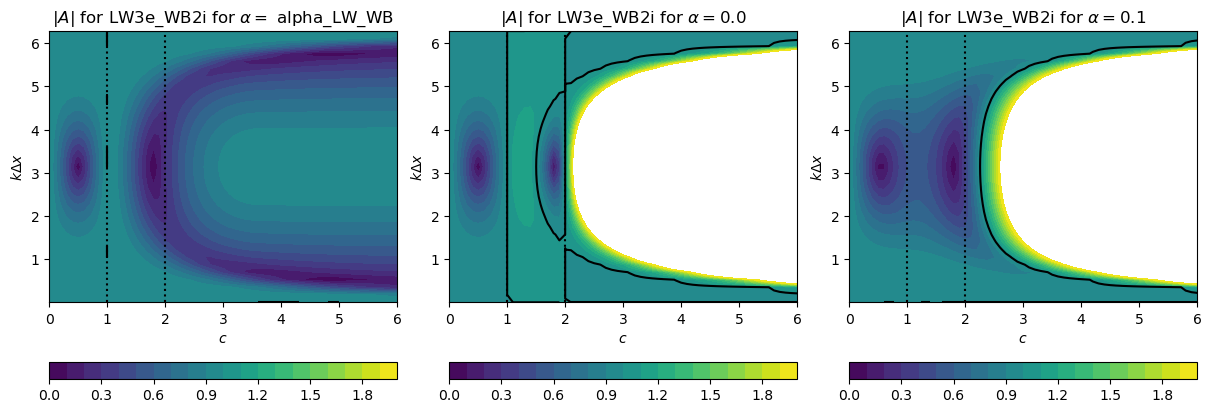

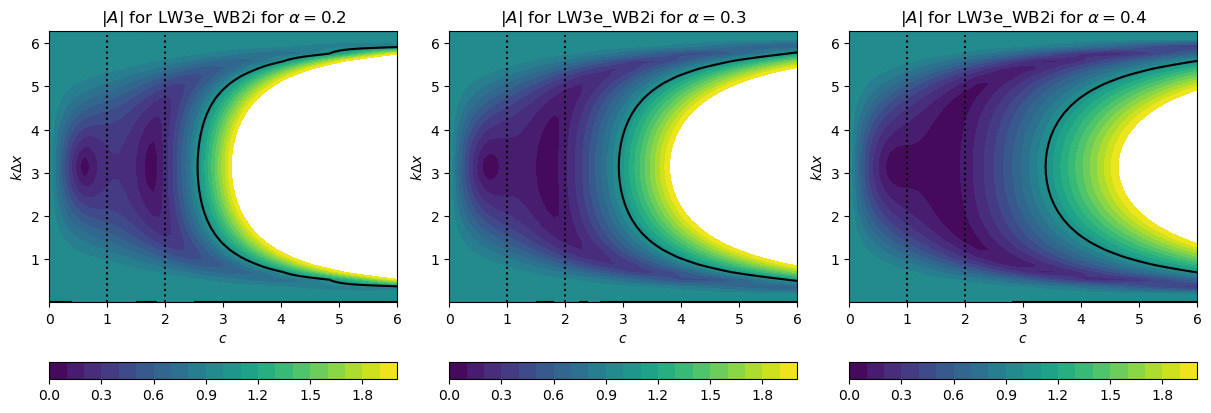

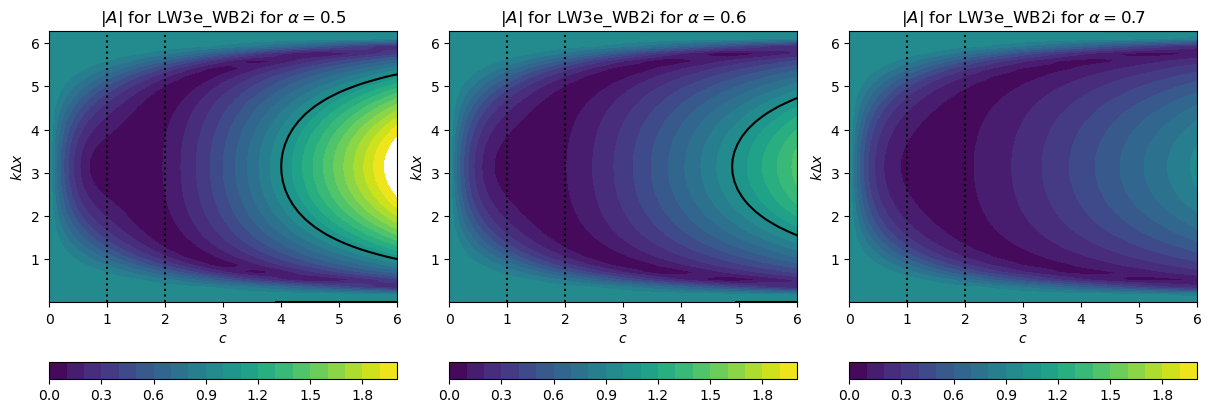

/tmp/ipykernel_45152/1554129439.py:20: UserWarning: No contour levels were found within the data range.
  axs[i%3].contour(cs, kdxs, magA, [0, 1], colors=['k', 'k'])


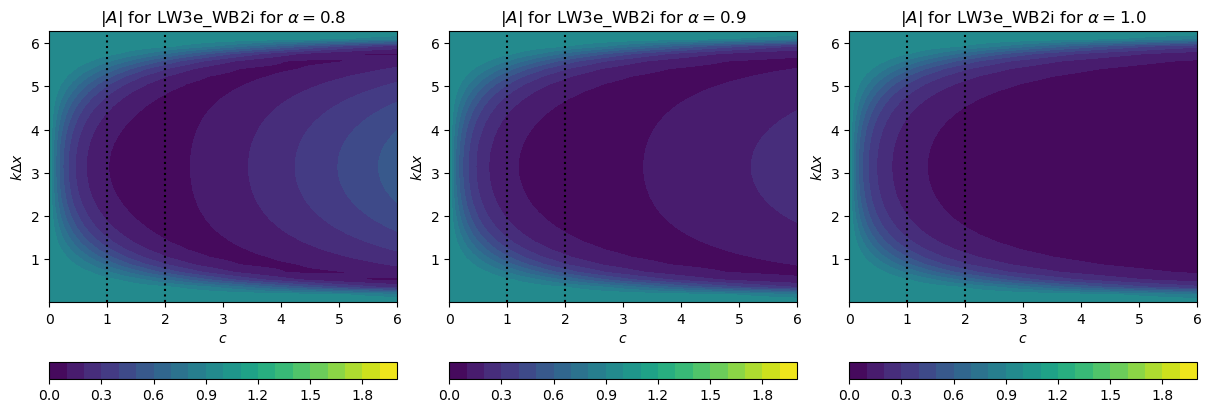

In [11]:
a = [alpha_LW_WB] + np.arange(0, 1.1, 0.1).tolist()
kdxs = np.linspace(1e-6, 2*np.pi, 37)
cs = np.arange(0, 6.1, 0.1)
magA = np.zeros([len(kdxs), len(cs)])
for i in range(len(a)):
    if i%3 == 0:
        fig,axs = plt.subplots(1,3, figsize=(12,4), layout='constrained')
    for ic in range(len(cs)):
        co = cs[ic]
        ai = a[i]
        if callable(a[i]):
            ai = a[i](co)
        for ik in range(len(kdxs)):
            kdx = kdxs[ik]
            magA[ik,ic] = abs(A_lw3e_wb2i(co, ai,kdx))
    axplot = axs[i%3].contourf(cs, kdxs,magA, np.arange(0, 2.1, 0.1))
    axs[i%3].axvline(x=1, color="black", linestyle=":")
    axs[i%3].axvline(x=2, color="black", linestyle=":")
    fig.colorbar(axplot,ax=axs[i%3], orientation='horizontal')
    axs[i%3].contour(cs, kdxs, magA, [0, 1], colors=['k', 'k'])
    axs[i%3].set(xlabel=r'$c$', ylabel=r'$k\Delta x$')
    if callable(a[i]):
        axs[i%3].set(title = r'$|A|$ for LW3e_WB2i for $\alpha=$ alpha_LW_WB')
    else:
        axs[i%3].set(title = r'$|A|$ for LW3e_WB2i for $\alpha=$'+str(round(ai,2)))
    if i%3 == 2:
        plt.show()

In [12]:
def WB2iMatrix(nx, c, a):
    """The matrix for the implicit WB2i
    nx: nx by nx matrix
    c: Courant number
    a: Off-centering"""

    # The coefficients for j-2, j-1, j
    #                       0    1   2
    m = np.zeros(3)
    for j in range(len(m)):
        M_j = sy.expand(WB2i).coeff(Psi[j])
        m[j] = -a*M_j.subs({C: c})
    m[2] += 1
    
    M = diags([m[0]*np.ones(nx-2), # The diagonal for j-2
               m[1]*np.ones(nx-1), # The diagonal for j-1
               m[2]*np.ones(nx), # The diagonal
               m[0]*np.ones(2), # the diagonal next to the top right  corner (j-2)
               m[1]], # the top right corner (j-1)
               [-2, -1, 0, nx-2, nx-1], # the locations of each of the diagonals
               shape=(nx,nx), format = 'csr')
    return M

# Model runs lf LW3e_WB2i

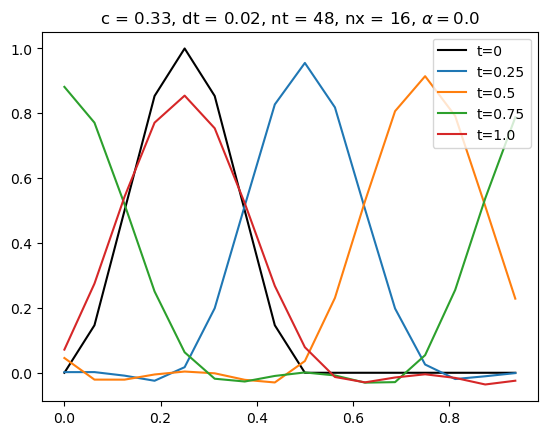

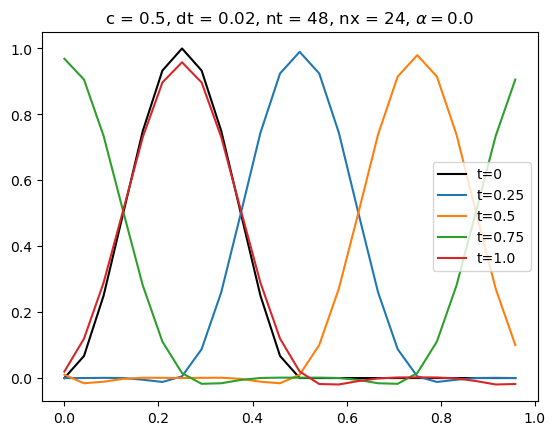

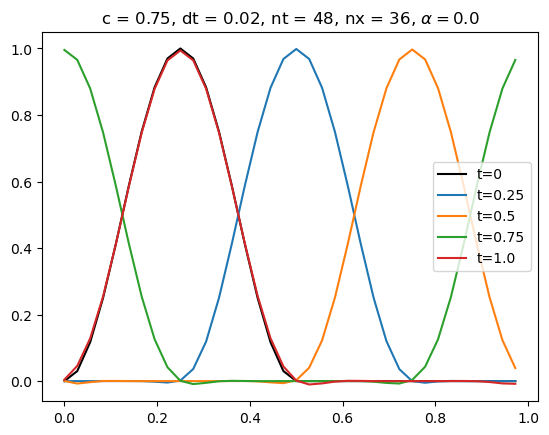

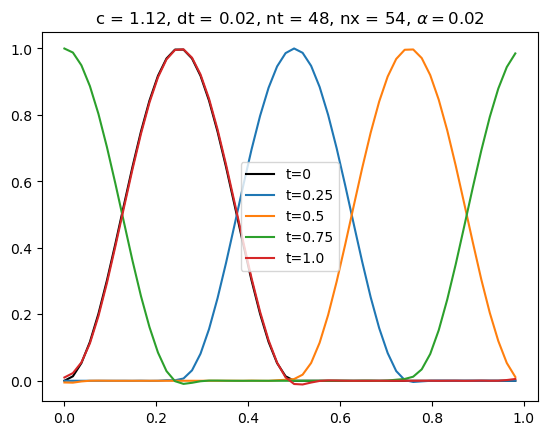

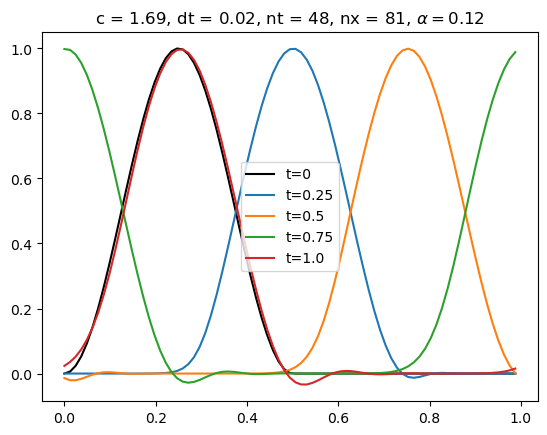

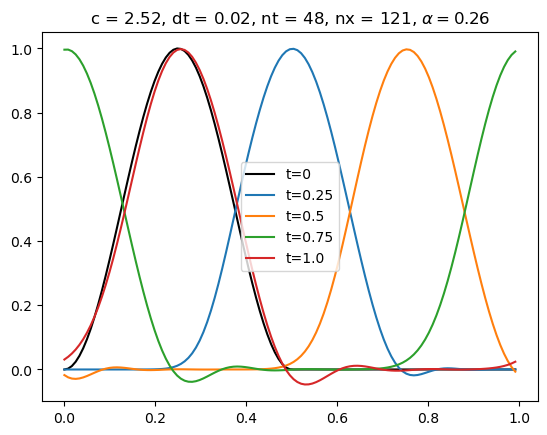

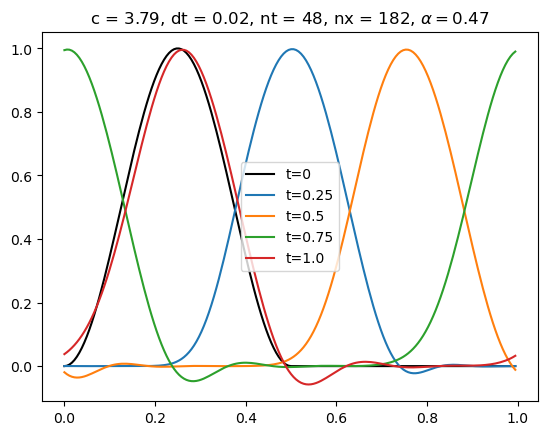

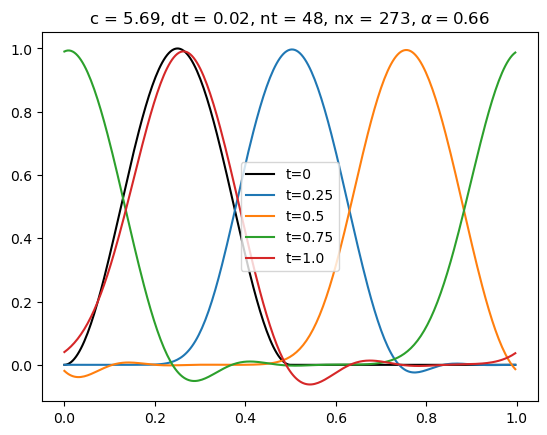

In [13]:
# Model runs of LW3e_WB2i
# Parameters for some revolutions of the periodic domain
nRevs = 1
nt = 48*nRevs
plotFreq = 12
dt = nRevs/nt
nxs = 16*1.5**np.arange(0, 8,1)

for i in range(len(nxs)):
    nx = int(nxs[i])
    c = nRevs*nx/nt
    a = alpha_LW_WB(c)[()]
    #chi_ = chi(c)
    chi_ = {"chi2": 1, "chi3": 1}
    Me = LW3eMatrix(nx, c, a, chi_["chi2"], chi_["chi3"])
    Mi = WB2iMatrix(nx, c, a)
    
    dx = 1/nx
    x = np.arange(0, 1, dx)
    phi0 = np.where(x<0.5, 0.5*(1-np.cos(4*np.pi*x)), 0.)
    phi = phi0.copy()
    plt.plot(x, phi, 'k', label = 't=0')
    for it in range(nt):
        phi = advect(phi, Me, Mi)
        if (it+1)%plotFreq == 0:
            plt.plot(x, phi, label = 't='+str(round((it+1)*dt, 2)))
    plt.legend()
    plt.title('c = '+str(round(c,2))+', dt = '+str(round(dt,2))
               +', nt = '+str(nt)+', nx = '+str(nx)
             +r', $\alpha=$'+str(round(a,2)))
    plt.show()

In [14]:
#help(sy.lambdify)
#help(Fr)
#a = Fr(1,2)
#print(a.numerator, a.denominator)
#from sympy.abc import x, y
#a = sy.fraction(x/y)
#print(a[0], a[1], a)
#help(sy.fraction)
#help(sy.polys.polytools.poly_from_expr)
#help(sy.polys.polytools)
#help(sy.Expr.coeff)
#import scipy.sparse
#help(scipy.sparse.spmatrix)